## COD API, One Match --> explore API, format, clean & reshape, test some visualizations

In [1]:
import asyncio
import os
import sys
import dotenv
from pprint import pprint
import datetime
from datetime import datetime, timezone, timedelta
import pandas as pd
import numpy as np
import pickle
from itertools import product

import altair as alt

import callofduty
from callofduty import Mode, Platform, Title, TimeFrame, GameType, Language

In [2]:
# Using SSO
# We're storing our SSO token in an .env file stored locally to separate our config from code (w. python-dotenv). An.env-template file (with help to retrieve token) is provided for you to edit and populate the variable(s)
# callofduty.py client .Login() goes through all the authentification steps and initiate a session to access protected routes
# The client is asynchronous thus the 'await style'
from dotenv import load_dotenv
load_dotenv()
client = await callofduty.Login(sso=os.environ["SSO"])

In [3]:
# we're storing our strings conversion module above current working (notebooks) directory
sys.path.insert(0, os.path.abspath('../wzkd'))
import labels
from labels import MODES_LABELS, WEAPONS_CAT_PREFIX, WEAPONS_CAT, CW_WEAPONS_CAT_SUFFIX, WEAPONS_CAT_LABELS, WEAPONS_LABELS

In [4]:
import urllib.parse
from typing import List, Optional, Union

from callofduty.client import Client
from callofduty.http import HTTP
from callofduty.http import Request

async def GetMatchStats(
    self, platform, title: Title, mode: Mode, matchId: int, language: Language = Language.English, **kwargs
):
    """ 
    Compared to client : modified so that we do not use Platform.abc as parameter
    but instead our app-defined workflow (drop down menu) to select our platform of choice"
    """
    return (
        await self.http.GetFullMatch(
            title.value, platform, mode.value, matchId, language.value
        )
    )["data"]["allPlayers"]
    # api result, at very least for Warzone {'data':{'all_players:' is the only key},'status': call status}

Client.GetMatchStats = GetMatchStats
match = await client.GetMatchStats('battle', Title.ModernWarfare, Mode.Warzone, matchId=2976279808342734071)

# example of IDs :
# 11672696746036290501 a "custom" mode game (Rumble Clash)
# 6825832239054239925 : Iron Trials Trios
# 9207377216339591388 : BR Duo

#### Option : save match to disk

In [5]:
#save file if you want to work in offline mode
with open("match.pkl", 'wb') as f:
    pickle.dump(match, f)

### Overview of returned (Match) stats

In [6]:
# load offline data
open_file = open("match.pkl", "rb")
match = pickle.load(open_file)
open_file.close()

In [7]:
pprint(match[0:2], depth=5)

[{'draw': False,
  'duration': 1659000,
  'gameType': 'wz',
  'map': 'mp_don4',
  'matchID': '2976279808342734071',
  'mode': 'br_brtrios',
  'player': {'awards': {},
             'brMissionStats': {'missionStatsByType': {'domination': {...}},
                                'missionsComplete': 1,
                                'totalMissionWeaponXpEarned': 420.0,
                                'totalMissionXpEarned': 700.0},
             'loadout': [{'extraPerks': [...],
                          'killstreaks': [...],
                          'lethal': {...},
                          'perks': [...],
                          'primaryWeapon': {...},
                          'secondaryWeapon': {...},
                          'tactical': {...}},
                         {'extraPerks': [...],
                          'killstreaks': [...],
                          'lethal': {...},
                          'perks': [...],
                          'primaryWeapon': {...},
          

In [8]:
print(match[0]['player'].keys(), "\n")
pprint(match[0]['player'], depth=3)

dict_keys(['team', 'rank', 'awards', 'username', 'uno', 'loadouts', 'brMissionStats', 'loadout']) 

{'awards': {},
 'brMissionStats': {'missionStatsByType': {'domination': {...}},
                    'missionsComplete': 1,
                    'totalMissionWeaponXpEarned': 420.0,
                    'totalMissionXpEarned': 700.0},
 'loadout': [{'extraPerks': [...],
              'killstreaks': [...],
              'lethal': {...},
              'perks': [...],
              'primaryWeapon': {...},
              'secondaryWeapon': {...},
              'tactical': {...}},
             {'extraPerks': [...],
              'killstreaks': [...],
              'lethal': {...},
              'perks': [...],
              'primaryWeapon': {...},
              'secondaryWeapon': {...},
              'tactical': {...}}],
 'loadouts': [{'extraPerks': [...],
               'killstreaks': [...],
               'lethal': {...},
               'perks': [...],
               'primaryWeapon': {...},
    

In [9]:
raw = pd.DataFrame(match)
raw.head(2)

,utcStartSeconds,utcEndSeconds,map,mode,matchID,duration,playlistName,version,gameType,playerCount,playerStats,player,teamCount,rankedTeams,draw,privateMatch
0,1636399097,1636400756,mp_don4,br_brtrios,2976279808342734071,1659000,None,1,wz,150,"{'kills': 2.0, 'medalXp': 10.0, 'matchXp': 104...","{'team': 'team_eighteen', 'rank': 54.0, 'award...",51,None,False,False
1,1636399097,1636400756,mp_don4,br_brtrios,2976279808342734071,1659000,None,1,wz,150,"{'kills': 3.0, 'medalXp': 30.0, 'objectiveLast...","{'team': 'team_thirty_one', 'rank': 54.0, 'awa...",51,None,False,False


#### playerStats col

In [10]:
players_stats = raw['playerStats'].apply(pd.Series)
players_stats.head(5)

,kills,medalXp,matchXp,scoreXp,wallBangs,score,totalXp,headshots,assists,challengeXp,...,objectiveTeamWiped,objectiveBrDownEnemyCircle3,objectiveBrDownEnemyCircle5,objectiveBrDownEnemyCircle6,objectiveDestroyedEquipment,objectiveMedalScoreSsKillPrecisionAirstrike,objectiveBrDownEnemyCircle4,objectiveDestroyedVehicleHeavy,objectiveTrophyDefense,objectiveDestroyedVehicleMedium
0,2.0,10.0,10448.0,5940.0,0.0,4200.0,16490.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,30.0,7263.0,7020.0,0.0,3000.0,14487.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,10.0,8331.0,5775.0,0.0,2775.0,14116.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,5638.0,4250.0,0.0,4150.0,9888.0,0.0,0.0,0.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,289.0,0.0,0.0,0.0,289.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
players_stats.keys()

Index(['kills', 'medalXp', 'matchXp', 'scoreXp', 'wallBangs', 'score',
       'totalXp', 'headshots', 'assists', 'challengeXp', 'rank',
       'scorePerMinute', 'distanceTraveled', 'teamSurvivalTime', 'deaths',
       'objectiveMunitionsBoxTeammateUsed', 'kdRatio',
       'objectiveBrDownEnemyCircle2', 'objectiveBrMissionPickupTablet',
       'bonusXp', 'objectiveBrKioskBuy', 'gulagDeaths', 'timePlayed',
       'executions', 'gulagKills', 'nearmisses', 'objectiveBrCacheOpen',
       'percentTimeMoving', 'miscXp', 'longestStreak', 'teamPlacement',
       'damageDone', 'damageTaken', 'objectiveLastStandKill',
       'objectiveBrDownEnemyCircle1', 'objectiveReviver', 'objectiveTeamWiped',
       'objectiveBrDownEnemyCircle3', 'objectiveBrDownEnemyCircle5',
       'objectiveBrDownEnemyCircle6', 'objectiveDestroyedEquipment',
       'objectiveMedalScoreSsKillPrecisionAirstrike',
       'objectiveBrDownEnemyCircle4', 'objectiveDestroyedVehicleHeavy',
       'objectiveTrophyDefense', 'objecti

In [12]:
players_stats[['objectiveBrDownEnemyCircle1']].sort_values(by="objectiveBrDownEnemyCircle1",ascending=False).head(10)

,objectiveBrDownEnemyCircle1
142,8.0
7,7.0
135,6.0
42,6.0
90,6.0
97,4.0
26,4.0
41,4.0
37,4.0
60,4.0


#### player col

In [13]:
players = raw['player'].apply(pd.Series)
players.head(5)

,team,rank,awards,username,uno,loadouts,brMissionStats,loadout,clantag
0,team_eighteen,54.0,{},Confetti_Seeker,13831131263765265947,[{'primaryWeapon': {'name': 'iw8_sm_t9fastfire...,"{'missionsComplete': 1, 'totalMissionXpEarned'...",[{'primaryWeapon': {'name': 'iw8_sm_t9fastfire...,NaN
1,team_thirty_one,54.0,{},maxbonbonkoch,17559140468322062650,"[{'primaryWeapon': {'name': 'iw8_sm_t9cqb', 'l...","{'missionsComplete': 2, 'totalMissionXpEarned'...","[{'primaryWeapon': {'name': 'iw8_sm_t9cqb', 'l...",NaN
2,team_thirty,54.0,{},The Fonz,2149090398057086098,[{'primaryWeapon': {'name': 'iw8_ar_t9slowhand...,"{'missionsComplete': 0, 'totalMissionXpEarned'...",[{'primaryWeapon': {'name': 'iw8_ar_t9slowhand...,NaN
3,team_twenty_five,54.0,{},BarbaRoja,2615663476462684704,"[{'primaryWeapon': {'name': 'iw8_sm_t9cqb', 'l...","{'missionsComplete': 0, 'totalMissionXpEarned'...","[{'primaryWeapon': {'name': 'iw8_sm_t9cqb', 'l...",NaN
4,team_fifty,54.0,{},MattSmith7,16235886313749315257,"[{'primaryWeapon': {'name': 'iw8_ar_mcharlie',...","{'missionsComplete': 0, 'totalMissionXpEarned'...","[{'primaryWeapon': {'name': 'iw8_ar_mcharlie',...",NaN


In [14]:
players.keys()

Index(['team', 'rank', 'awards', 'username', 'uno', 'loadouts',
       'brMissionStats', 'loadout', 'clantag'],
      dtype='object')

In [15]:
df_match = pd.DataFrame(match)
df_match.head(3)

,utcStartSeconds,utcEndSeconds,map,mode,matchID,duration,playlistName,version,gameType,playerCount,playerStats,player,teamCount,rankedTeams,draw,privateMatch
0,1636399097,1636400756,mp_don4,br_brtrios,2976279808342734071,1659000,None,1,wz,150,"{'kills': 2.0, 'medalXp': 10.0, 'matchXp': 104...","{'team': 'team_eighteen', 'rank': 54.0, 'award...",51,None,False,False
1,1636399097,1636400756,mp_don4,br_brtrios,2976279808342734071,1659000,None,1,wz,150,"{'kills': 3.0, 'medalXp': 30.0, 'objectiveLast...","{'team': 'team_thirty_one', 'rank': 54.0, 'awa...",51,None,False,False
2,1636399097,1636400756,mp_don4,br_brtrios,2976279808342734071,1659000,None,1,wz,150,"{'kills': 1.0, 'medalXp': 10.0, 'matchXp': 833...","{'team': 'team_thirty', 'rank': 54.0, 'awards'...",51,None,False,False


In [16]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   utcStartSeconds  150 non-null    int64 
 1   utcEndSeconds    150 non-null    int64 
 2   map              150 non-null    object
 3   mode             150 non-null    object
 4   matchID          150 non-null    object
 5   duration         150 non-null    int64 
 6   playlistName     0 non-null      object
 7   version          150 non-null    int64 
 8   gameType         150 non-null    object
 9   playerCount      150 non-null    int64 
 10  playerStats      150 non-null    object
 11  player           150 non-null    object
 12  teamCount        150 non-null    int64 
 13  rankedTeams      0 non-null      object
 14  draw             150 non-null    bool  
 15  privateMatch     150 non-null    bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 16.8+ KB


### Functions to format Match result

In [17]:
def MatchPlayersToDf(match):
    """
    Convert Match result to a DataFrame we we can perform our aggregations nicely, later.
    Expand some entries (i.e player, playerstats) that are deeply nested.
    Filter out / retains columns.
    Built mainly to analyze a 'BR' match, but we made sure it should work for other match types
    
    Parameters
    ----------
    match : result from COD API "match" endpoint ; FYI formated as : 
        list[
                dict{ player 1 match stats },
                dict{ player 2 match stats },
                dict{ +- 150 players },
            ]
    
    Returns
    -------
    DataFrame, a match stats with players as rows, matches/player stats as columns/values
    """
    
    
    keep_cols =  [
        'mode',
        'utcEndSeconds',
        'team',
        'username',
        'timePlayed',
        'teamPlacement',
        'kdRatio', 
        'kills', 
        'deaths', 
        'assists', 
        'damageDone',
        'damageTaken',
        'gulagKills',
        'percentTimeMoving',
        'duration'
        ]
    
    df = pd.DataFrame(match)
    
    # column playerStats is a series of dict, we can expand it easily and append, then drop the original
    df = pd.concat([df.drop(['playerStats'], axis=1), df['playerStats'].apply(pd.Series)], axis=1)
    
    # colum 'player' has more depth
    # once expanded, it has a column 'loadout' : a series of list of dict (either one or more, we will max 3)
    # and also brMissionStats (mostly empty ?, a col only present in BR matches) that we aren't interested in
    
    df = pd.concat([df.drop(['player'], axis=1), df['player'].apply(pd.Series)], axis=1)
    if 'brMissionStats' in df.columns:
        df = df.drop(['brMissionStats'], axis = 1)
    df = pd.concat([df.drop(['loadout'], axis=1), df['loadout'].apply(pd.Series)], axis=1)
    for col in range(0,3):
        if col in df.columns:
            df[col] = df[col].apply(lambda x: f"{x['primaryWeapon']['name']} - {x['secondaryWeapon']['name']}" if not str(x) == 'nan' else np.nan)
            col_name = "loadout_" + str(col +1)
            df = df.rename(columns={col: f"loadout_{str(col +1)}"})   
            keep_cols.append(col_name)
    
    # Ensure we are not throwing an error if we want to keep a column that does not exist (i.e. not in a BR match) :
    keep_cols = [col for col in keep_cols if col in df.columns.tolist()]
    
    return df[keep_cols]

In [18]:
open_file = open("match.pkl", "rb")
match = pickle.load(open_file)
open_file.close()

In [19]:
df_match = MatchPlayersToDf(match)
df_match.head(3)

,mode,utcEndSeconds,team,username,timePlayed,teamPlacement,kdRatio,kills,deaths,assists,damageDone,damageTaken,gulagKills,percentTimeMoving,duration,loadout_1,loadout_2,loadout_3
0,br_brtrios,1636400756,team_eighteen,Confetti_Seeker,1271.0,12.0,1.000000,2.0,2.0,2.0,327.0,326.0,1.0,88.72305,1659000,iw8_sm_t9fastfire - iw8_sn_t9accurate,iw8_pi_t9semiauto - iw8_fists,NaN
1,br_brtrios,1636400756,team_thirty_one,maxbonbonkoch,896.0,24.0,1.000000,3.0,3.0,0.0,1350.0,609.0,0.0,78.52760,1659000,iw8_sm_t9cqb - iw8_ar_t9slowfire,iw8_pi_t9semiauto - iw8_fists,iw8_sn_t9damagesemi - iw8_fists
2,br_brtrios,1636400756,team_thirty,The Fonz,1043.0,21.0,0.333333,1.0,3.0,1.0,475.0,574.0,1.0,66.53020,1659000,iw8_ar_t9slowhandling - iw8_sm_t9fastfire,iw8_pi_t9semiauto - iw8_fists,iw8_ar_t9slowhandling - iw8_pi_mike


In [20]:
df_match[df_match['username'] == 'gentil_renard']

,mode,utcEndSeconds,team,username,timePlayed,teamPlacement,kdRatio,kills,deaths,assists,damageDone,damageTaken,gulagKills,percentTimeMoving,duration,loadout_1,loadout_2,loadout_3
49,br_brtrios,1636400756,team_eighteen,gentil_renard,1289.0,12.0,1.0,2.0,2.0,0.0,343.0,469.0,1.0,92.53112,1659000,iw8_sh_dpapa12 - iw8_sn_t9powersemi,iw8_pi_t9semiauto - iw8_fists,NaN


In [21]:
def MatchPlayersStandardize(df):
    """
    A first layer of standadization (as properly formated) to our a "Match with players stats" DataFrame
    For further aggregations / better readibility of our data
    
    Returns
    -------
    DataFrame : players/teams as rows, cleaned player stats of a given match as columns
    """
    
    int_cols =  [
        'teamPlacement', 
        'kills', 
        'deaths', 
        'assists', 
        'gulagKills', 
        'damageDone',
        'damageTaken'
        ]
    
    float_cols = [
        'kdRatio',
        'percentTimeMoving'
        ]
    
    ts_cols = [
        'utcEndSeconds'
        ]
    
    columns_labels = {
        'utcEndSeconds':'Ended at',
        'timePlayed': 'Playtime',
        'teamPlacement':'#',
        'kdRatio':'KD',
        'damageDone':'Damage >',
        'damageTaken':'Damage <',
        'gulagKills':'Gulag',
        'headshots':'% headshots',
        'percentTimeMoving':'% moving',
        'duration':'Game duration'
        }

    # Ensure we are not throwing an error if we want to keep a column that does not exist (i.e. not in a BR match) :
    int_cols = [col for col in int_cols if col in df.columns.tolist()]
    
    # df = df.fillna(0)
    # generic conversions/rounding for int and float cols
    df[int_cols] = df[int_cols].astype(int)
    df[float_cols] = df[float_cols].astype(float).round(1) # still renders 0.0000 in streamlit but ugly hacks exists
    
    # specials : timestamp, loadout columns, match type...
    df.team = df.team.apply(lambda x: x.replace("team_", ""))
    df['utcEndSeconds'] = df['utcEndSeconds'].apply(lambda x: datetime.fromtimestamp(x))
    
    df['duration'] = df['duration'].apply(lambda x: x/1000).apply(lambda x: pd.to_datetime(x, unit='s').strftime('%M')) # API duration is in seconds x1000
    df['timePlayed'] = df['timePlayed'].apply(lambda x: pd.to_datetime(x, unit='s').strftime('%M:%S')) # API timePlayed is in seconds
    if 'gulagKills' in df.columns.tolist():
        df['gulagKills'] = df['gulagKills'].map({1:'W', 0:'L'})
    for col in ['loadout_1', 'loadout_2', 'loadout_3']:
            df.fillna({col:'-'}, inplace=True) if col in df.columns else None
    
    df = df.replace({"mode": MODES_LABELS})
    df = df.rename(columns=columns_labels)
    df.columns = df.columns.str.capitalize()
    df = df.rename({"Kd":"KD"}, axis=1)
     
    return df

In [22]:
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
df.tail(3)

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
147,Trios,2021-11-08 20:45:56,twenty_six,Rev,11:34,34,0.0,0,3,0,377,466,L,64.1,27,iw8_ar_kilo433 - iw8_sm_mpapa5,iw8_sh_t9pump - iw8_fists,-
148,Trios,2021-11-08 20:45:56,eight,normajean74,13:37,27,2.0,4,2,0,1487,642,W,87.6,27,iw8_lm_t9fastfire - iw8_sm_t9standard,iw8_pi_t9semiauto - iw8_fists,-
149,Trios,2021-11-08 20:45:56,twenty_six,JacalL141,11:58,34,0.3,1,3,0,614,698,W,60.2,27,iw8_ar_t9damage - iw8_me_riotshield,iw8_pi_t9semiauto - iw8_fists,-


### Retrieve some matche basic infos

In [23]:
def retrieveTeam(df, gamertag):
    """ --> df, Retrieve team name of given gamertag"""    
    return df[df["Username"] == gamertag]['Team'].tolist()[0]  

def retrieveTeammates(df, gamertag):
    """ --> df, Retrieve list of gamertag + his teammates"""  
    team = retrieveTeam(df, gamertag)
    return df[df["Team"] == team]['Username'].tolist()

def retrieveDate(df):
    """ --> str, Retrieve end date (str) of our match """   
    return df['Ended at'][0].strftime('%Y-%m-%d %H:%M')

def retrievePlacement(df, gamertag):
    """ --> int, Retrieve final placement of a player/his team """  
    return df[df["Username"] == gamertag]["#"].tolist()[0]

def retrievePlayerKills(df, gamertag):
    """ --> dict, Retrieve Player Kills kpis"""
    return df[df["Username"] == gamertag][["KD", "Kills", "Deaths"]].to_dict('records')[0]

In [24]:
df.head()

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
0,Trios,2021-11-08 20:45:56,eighteen,Confetti_Seeker,21:11,12,1.0,2,2,2,327,326,W,88.7,27,iw8_sm_t9fastfire - iw8_sn_t9accurate,iw8_pi_t9semiauto - iw8_fists,-
1,Trios,2021-11-08 20:45:56,thirty_one,maxbonbonkoch,14:56,24,1.0,3,3,0,1350,609,L,78.5,27,iw8_sm_t9cqb - iw8_ar_t9slowfire,iw8_pi_t9semiauto - iw8_fists,iw8_sn_t9damagesemi - iw8_fists
2,Trios,2021-11-08 20:45:56,thirty,The Fonz,17:23,21,0.3,1,3,1,475,574,W,66.5,27,iw8_ar_t9slowhandling - iw8_sm_t9fastfire,iw8_pi_t9semiauto - iw8_fists,iw8_ar_t9slowhandling - iw8_pi_mike
3,Trios,2021-11-08 20:45:56,twenty_five,BarbaRoja,12:28,31,0.5,1,2,0,606,340,L,94.5,27,iw8_sm_t9cqb - iw8_sn_t9accurate,-,-
4,Trios,2021-11-08 20:45:56,fifty,MattSmith7,00:59,51,0.0,0,0,0,0,0,L,90.9,27,iw8_ar_mcharlie - iw8_la_rpapa7,-,-


In [25]:
gamertag = "gentil_renard"
team = retrieveTeam(df, gamertag)
teammates = retrieveTeammates(df, gamertag)
print(team, teammates)

eighteen ['Confetti_Seeker', 'nicoyzovitch', 'gentil_renard']


In [26]:
placement = retrievePlacement(df, gamertag)
placement

12

In [27]:
player_kills = retrievePlayerKills(df, gamertag)
player_kills

{'KD': 1.0, 'Kills': 2, 'Deaths': 2}

### Sandbox Weapons cleaning

In [28]:
WEAPONS_CAT_PREFIX = ['iw8_']
WEAPONS_CAT = ["ar", "lm", "sm", "pi", "sn", "la", "sh", "me"]
CW_WEAPONS_CAT_SUFFIX = ['_t9']

WEAPONS_CAT_LABELS = {
    'ar':'Ar',
    'lm':'Lmg',
    'sm':'Smg',
    'pi':'Pistol',
    'sn':'Sniper',
    'la':'Launcher',
    'sh':'Shotgun',
    'me':'Melee'
}

WEAPONS_LABELS = {
    'ar_falima': 'FAL',
    'ar_mcharlie': 'M13',
    'ar_mike4': 'M4A1',
    'ar_t9british': 'EM2',
    'ar_t9damage': 'AK-47 cw',
    'ar_t9season6': 'ground AR',
    'ar_t9slowhandling': 'Fara83',
    'ar_t9standard': 'XM4',
    'ar_valpha': 'ASVAL',
    'ar_sierra552': 'Grau 5.56',
    'sm_t9cqb':'OTs 9',
    'la_kgolf': 'Strela',
    'la_t9season6': 'ground launcher',
    'lm_t9fastfire': 'MG82',
    'lm_t9season6': 'ground lmg',
    'me_riotshield': 'Shield',
    'pi_t9season6': 'ground pistol',
    'pi_t9semiauto': 'Pistol',
    'sh_aalpha12': 'JAK-12',
    'sh_dpapa12': 'R9-0',
    'sh_t9season6': 'ground shotgun',
    'sm_t9capacity': 'Bullfrog',
    'sm_t9fastfire': 'MAC-10',
    'sm_t9season6': 'ground smg',
    'sm_t9spray': 'ppsh',
    'sm_t9standard': 'MP5 cw',
    'sn_cannon': 'ZRG',
    'sn_hdromeo': 'HDR',
    'sn_kilo98': 'Kar98',
    'sn_t9accurate': 'K31',
    'sn_t9powersemi': 'M82',
    'sn_t9season6': 'ground sniper'
    }

WEAPONS_LABELS = dict(sorted(WEAPONS_LABELS.items()))

In [29]:
WEAPONS_LABELS

{'ar_falima': 'FAL',
 'ar_mcharlie': 'M13',
 'ar_mike4': 'M4A1',
 'ar_sierra552': 'Grau 5.56',
 'ar_t9british': 'EM2',
 'ar_t9damage': 'AK-47 cw',
 'ar_t9season6': 'ground AR',
 'ar_t9slowhandling': 'Fara83',
 'ar_t9standard': 'XM4',
 'ar_valpha': 'ASVAL',
 'la_kgolf': 'Strela',
 'la_t9season6': 'ground launcher',
 'lm_t9fastfire': 'MG82',
 'lm_t9season6': 'ground lmg',
 'me_riotshield': 'Shield',
 'pi_t9season6': 'ground pistol',
 'pi_t9semiauto': 'Pistol',
 'sh_aalpha12': 'JAK-12',
 'sh_dpapa12': 'R9-0',
 'sh_t9season6': 'ground shotgun',
 'sm_t9capacity': 'Bullfrog',
 'sm_t9cqb': 'OTs 9',
 'sm_t9fastfire': 'MAC-10',
 'sm_t9season6': 'ground smg',
 'sm_t9spray': 'ppsh',
 'sm_t9standard': 'MP5 cw',
 'sn_cannon': 'ZRG',
 'sn_hdromeo': 'HDR',
 'sn_kilo98': 'Kar98',
 'sn_t9accurate': 'K31',
 'sn_t9powersemi': 'M82',
 'sn_t9season6': 'ground sniper'}

In [30]:
# plunder weapons tests : 3730567781417063940
# trios : 2976279808342734071
# quads : 3761077364910334296
# trios : 2897643815664392564
# trios : 2261680546254418765
# duos with  nicoy : 2159402653441641458
# duos with  nicoy : 1331412334389642250

match = await client.GetMatchStats('battle', Title.ModernWarfare, Mode.Warzone, matchId=6819668192065006886)
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)

#save file if you want to work in offline mode
with open("match.pkl", 'wb') as f:
    pickle.dump(match, f)

In [31]:
# load offline data
open_file = open("match.pkl", "rb")
match = pickle.load(open_file)
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
open_file.close()

In [32]:
date = retrieveDate(df)
date

'2021-11-13 00:23'

In [33]:
df[df['Username'] == 'nicoyzovitch']

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
66,Duos,2021-11-13 00:23:53,forty_seven,nicoyzovitch,25:17,9,0.5,1,2,1,1060,540,W,81.6,27,iw8_ar_t9standard - iw8_sn_hdromeo,iw8_pi_t9semiauto - iw8_fists,-


In [34]:
df[df['Username'] == 'nicoyzovitch']

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
66,Duos,2021-11-13 00:23:53,forty_seven,nicoyzovitch,25:17,9,0.5,1,2,1,1060,540,W,81.6,27,iw8_ar_t9standard - iw8_sn_hdromeo,iw8_pi_t9semiauto - iw8_fists,-


In [35]:
loadouts = df.Loadout_1.values.tolist()
loadouts[0:20]

['iw8_sm_t9fastfire - iw8_sn_t9accurate',
 'iw8_sn_t9accurate - iw8_sm_t9spray',
 'iw8_ar_t9standard - iw8_sm_t9standard',
 'iw8_sm_t9capacity - iw8_sn_t9accurate',
 'iw8_sm_t9accurate - iw8_ar_t9slowhandling',
 'iw8_ar_t9standard - iw8_sm_t9season6',
 'iw8_sn_t9accurate - iw8_sm_t9cqb',
 'iw8_ar_t9standard - iw8_sm_t9standard',
 'iw8_ar_t9damage - iw8_sm_t9season6',
 'iw8_ar_t9damage - iw8_sm_t9standard',
 'iw8_sm_t9handling - iw8_sn_kilo98',
 'iw8_sm_t9cqb - iw8_sn_t9accurate',
 'iw8_sm_t9season6 - iw8_pi_mike',
 'iw8_sm_t9standard - iw8_ar_t9british',
 'iw8_ar_tango21 - iw8_sn_t9accurate',
 'iw8_ar_galima - iw8_sn_romeo700',
 'iw8_ar_t9damage - iw8_sn_t9accurate',
 'iw8_ar_t9damage - iw8_sm_t9cqb',
 'iw8_sm_t9cqb - iw8_pi_papa320',
 'iw8_lm_t9fastfire - iw8_pi_t9burst']

In [36]:
def convertWeapons(x):
    """ Clean Loadouts (weapons) columns, particul. using labels.py """
    
    # Cold War weapons format is iw8_sm_t9, iw8_ar_t9 etc. for Cold War,  Modern Warfare : iw8_ar, iw8_me etc. for MW
    if not x == "-":
        x = x.split(" - ")
        x = list(map(lambda weapon: weapon.replace(WEAPONS_CAT_PREFIX[0], ''), x))
        x = list(map(lambda weapon: WEAPONS_LABELS.get(weapon) or weapon, x))
        
        # After a won Gulag you (usually) spawn with 'fists' and season weapon (usually Pistols); remove 'fists'
        if 'fists' in x:
            x = list(map(lambda weapon: weapon.replace('fists', ''), x))
            x = x[0]
        else:
            x = ' - '.join(x)
    else:
        x = '-'
    return x

In [37]:
lw = [
    '-',
    'iw8_sm_t9season6 - iw8_pi_t9burst',
    'iw8_ar_sierra552 - iw8_sm_t9season6',
    'iw8_ar_t9season6 - iw8_sn_t9powersemi',
    'iw8_pi_t9semiauto - fists'
]

for string in lw:
    weapons = convertWeapons(string)
    print(weapons)

-
ground smg - pi_t9burst
Grau 5.56 - ground smg
ground AR - M82
Pistol


### Extract/calculate some specific KPI's

In [38]:
def teamWeapons(df, gamertag):
    """ Return a DataFrame with teammates and their loadouts (3 max) """
    team = retrieveTeam(df, gamertag)
    df_weapons = df[df["Team"] == team][df.columns[df.columns.str.startswith('Loadout')]]
    df_usernames = df[df["Team"] == team][['Username']]
    table_weapons = pd.concat([df_usernames, df_weapons], axis=1)
    for col in table_weapons.columns[table_weapons.columns.str.startswith('Loadout')]:
        table_weapons[col] = table_weapons[col].map(lambda x: convertWeapons(x))
    return table_weapons

def teamKills(df, gamertag):
    """ Return a DataFrame with Team players KD, K/D/A; also with agg stats for whole Team """
    team = retrieveTeam(df, gamertag)
    df_team = df[df["Team"] == team][['Username', 'KD', 'Kills', 'Deaths', 'Assists']]
    agg_func = {
        "KD":"sum",
        "Kills":"sum",
        "Deaths":"sum",
        "Assists":"sum"
    }
    team_kd = (df_team.Kills.sum() / df_team.Deaths.sum()).round(1)

    row_total = df_team.agg(agg_func).to_dict()
    row_total.update({'Username': 'Team'})
    row_total.update({'KD': team_kd})
    df_team = df_team.append(row_total, ignore_index=True)
    df_team[['Kills', 'Deaths', 'Assists']] = df_team[['Kills', 'Deaths', 'Assists']].astype(int)
    return df_team

def topPlayers(df):
    """  """
    df_top = df.sort_values(by="Kills",ascending=False)[0:5][
        ['Username', 'Team', 'KD', 'Kills', 'Deaths', 'Assists', 'Loadout_1', 'Loadout_2', 'Loadout_3']
        ]

    for col in df_top.columns[df_top.columns.str.startswith('Loadout')]:
        df_top[col] = df_top[col].map(lambda x: convertWeapons(x))
    return df_top

def teamKillsPlacement(df, gamertag):
    """ Retrieve final placement according to # kills, of a player/his team """ 
    index = df.groupby('Team')[['Kills']].sum().sort_values('Kills', ascending = False).reset_index()
    condition = index['Team'] == retrieveTeam(df, gamertag)
    return index[condition]['Kills'].index.tolist()[0]


In [39]:
open_file = open("match.pkl", "rb")
match = pickle.load(open_file)
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
open_file.close()

In [40]:
def playersQuartiles(df):
    """ All players, mean and median, quartiles """
    return df[['Kills', 'KD']].describe().to_dict()

In [41]:
players_quartiles = playersQuartiles(df)
players_quartiles

{'Kills': {'count': 149.0,
  'mean': 1.9395973154362416,
  'std': 2.322708658533217,
  'min': 0.0,
  '25%': 0.0,
  '50%': 1.0,
  '75%': 3.0,
  'max': 12.0},
 'KD': {'count': 149.0,
  'mean': 1.0771812080536913,
  'std': 1.6006384201551922,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.5,
  '75%': 1.5,
  'max': 11.0}}

In [42]:
df[['Team', 'KD', 'Kills']].groupby(['Team']).agg('mean', 'median')

,KD,Kills
Team,,
allies,1.75,2.5
axis,1.00,2.0
eight,1.00,2.0
eighteen,1.00,2.0
eleven,1.00,2.0
...,...,...
twenty_one,0.50,1.0
twenty_seven,0.00,0.0
twenty_six,4.75,9.5


In [43]:
df[['Team', 'Kills', 'Deaths']].groupby(['Team']).agg('sum').agg('median')

Kills     3.0
Deaths    4.0
dtype: float64

In [44]:
tkp = teamKillsPlacement(df, gamertag)
tkp

46

In [45]:
players_kills = topPlayers(df)
players_kills

,Username,Team,KD,Kills,Deaths,Assists,Loadout_1,Loadout_2,Loadout_3
1,izKKoTV,twenty_six,6.0,12,2,1,K31 - ppsh,Pistol,-
72,El Chapoo,twenty_five,11.0,11,1,0,MAC-10 - K31,Pistol,-
23,SeoiAlle,forty_eight,3.3,10,3,0,sm_t9handling - Kar98,Pistol,ar_t9fasthandling
91,carriola94,twenty_five,8.0,8,1,1,EM2 - MP5 cw,Pistol,-
122,UrCrush,nine,8.0,8,1,0,AK-47 cw - knife,Pistol,-


In [46]:
team_kills = teamKills(df, gamertag)
team_kills

,Username,KD,Kills,Deaths,Assists
0,nicoyzovitch,0.5,1,2,1
1,gentil_renard,0.5,1,2,0
2,Team,0.5,2,4,1


In [47]:
team_weapons = teamWeapons(df, gamertag)
team_weapons

,Username,Loadout_1,Loadout_2,Loadout_3
66,nicoyzovitch,XM4 - HDR,Pistol,-
71,gentil_renard,FAL - K31,-,-


In [48]:
dict_ = team_weapons.set_index('Username').to_dict('index')
for player, loadouts in dict_.items():
    print(f"{player}: {dict_[player]['Loadout_1']}, {dict_[player]['Loadout_2']}, {dict_[player]['Loadout_3']}")

nicoyzovitch: XM4 - HDR, Pistol, -
gentil_renard: FAL - K31, -, -


In [49]:
def shrinkDf(df, cols_to_concat, str_join, new_col):
    """ For our df to occupy less space in Streamlit : to str + concat some cols into one"""
    
    def concat_cols(df, cols_to_concat, str_join):
        return pd.Series(map(str_join.join, df[cols_to_concat].values.tolist()),index = df.index)
    
    for col in cols_to_concat:
        df[col] = df[col].astype(str)
    df[new_col] = concat_cols(df, cols_to_concat, str_join)
    df = df.drop(cols_to_concat, axis=1)
    
    return df

def renderTeam(team_kills, team_weapons):
    """ Render Team KDA concat with Team Weapons, in a plotly table"""

    team_kills = shrinkDf(team_kills, cols_to_concat=['Kills', 'Deaths', 'Assists'], str_join=' | ', new_col= 'K D A')
    team_weapons = shrinkDf(team_weapons, cols_to_concat=['Loadout_1', 'Loadout_2', 'Loadout_3'], str_join=', ', new_col='Loadouts')
        
    team_weapons.reset_index().drop('index', axis=1)
    pad_row = {'Username': 'Team', 'Loadouts': '-'}
    team_weapons = team_weapons.append(pad_row, ignore_index=True)
    team_weapons = team_weapons.drop('Username', axis=1)
    team_info = pd.concat([team_kills, team_weapons], axis=1, sort=True)
    team_info = team_info.rename(columns={"Username": "Player"})
    
    return team_info

def renderPlayers(players_kills):
    """ Render Team KDA concat with Team Weapons, in a plotly table"""

    players_kills = shrinkDf(players_kills, cols_to_concat=['Kills', 'Deaths', 'Assists'], str_join=' | ', new_col= 'K D A')
    players_kills = shrinkDf(players_kills, cols_to_concat=['Loadout_1', 'Loadout_2', 'Loadout_3'], str_join=', ', new_col= 'Loadouts')
    players_kills = players_kills.rename(columns={"Username": "Player"})
    
    return players_kills

In [50]:
team_kills = renderTeam(team_kills, team_weapons)
team_kills

,Player,KD,K D A,Loadouts
0,nicoyzovitch,0.5,1 | 2 | 1,"XM4 - HDR, Pistol, -"
1,gentil_renard,0.5,1 | 2 | 0,"FAL - K31, -, -"
2,Team,0.5,2 | 4 | 1,-


In [51]:
top_players = renderPlayers(players_kills)
top_players

,Player,Team,KD,K D A,Loadouts
1,izKKoTV,twenty_six,6.0,12 | 2 | 1,"K31 - ppsh, Pistol, -"
72,El Chapoo,twenty_five,11.0,11 | 1 | 0,"MAC-10 - K31, Pistol, -"
23,SeoiAlle,forty_eight,3.3,10 | 3 | 0,"sm_t9handling - Kar98, Pistol, ar_t9fasthandling"
91,carriola94,twenty_five,8.0,8 | 1 | 1,"EM2 - MP5 cw, Pistol, -"
122,UrCrush,nine,8.0,8 | 1 | 0,"AK-47 cw - knife, Pistol, -"


### Visualizations sandbox

#### Using Altair vega

In [63]:
open_file = open("match.pkl", "rb")
match = pickle.load(open_file)
open_file.close()
df_match = MatchPlayersToDf(match)
df = MatchPlayersStandardize(df_match)
df.head(2)

,Mode,Ended at,Team,Username,Playtime,#,KD,Kills,Deaths,Assists,Damage >,Damage <,Gulag,% moving,Game duration,Loadout_1,Loadout_2,Loadout_3
0,Duos,2021-11-13 00:23:53,fifty_nine,JUREK KILLER,12:47,24,0.3,1,3,1,468,657,W,69.8,27,iw8_sm_t9fastfire - iw8_sn_t9accurate,iw8_pi_t9semiauto - iw8_fists,iw8_pi_t9semiauto - iw8_fists
1,Duos,2021-11-13 00:23:53,twenty_six,izKKoTV,27:38,3,6.0,12,2,1,4101,796,W,83.2,27,iw8_sn_t9accurate - iw8_sm_t9spray,iw8_pi_t9semiauto - iw8_fists,-


In [53]:
base = alt.Chart(df)         
hist2 = base.mark_bar().encode(
    x=alt.X('Kills:Q', bin=alt.BinParams(step=1)),
    y=alt.Y('count()', axis=alt.Axis(format='', title='n Players')),
    tooltip=['Kills'],
    color=alt.value("orange")

).properties(width=400, height=300)         
red_median_line = base.mark_rule(color='red').encode(
    x=alt.X('median(Kills):Q', title='Kills'),
    size=alt.value(3)
)
hist2 + red_median_line

alt.LayerChart(...)

In [54]:
base = alt.Chart(df)

hist2 = base.mark_bar().encode(
    x=alt.X('Kills:Q', bin=alt.BinParams(step=1)),
    y=alt.Y('count()', axis=alt.Axis(tickCount=10, format='', title='n Players')),
    tooltip=['Kills', 'count()'],
    color=alt.value("orange")
            
).properties(width=400, height=200)

red_median_line = base.mark_rule(color='black').encode(
    x=alt.X('median(KD):Q', title='KD'),
    size=alt.value(2)
)

hist2 + red_median_line

alt.LayerChart(...)

In [55]:
hist2 = base.mark_bar().encode(
    x=alt.X('KD:Q', bin=alt.Bin(step=0.5)), 
    y=alt.Y('count()', axis=alt.Axis(format='', title='n Players')),
    tooltip=['KD', 'count()'],
    color=alt.value("orange")
            
).properties(width=400, height=300)

red_median_line2 = base.mark_rule(color='black').encode(
    x=alt.X('median(KD):Q', title='KD'),
    size=alt.value(2)
)
hist2 + red_median_line2

alt.LayerChart(...)

#### Using Plotly

##### Tables

In [56]:
import plotly.graph_objects as go

In [57]:
team_kills

,Player,KD,K D A,Loadouts
0,nicoyzovitch,0.5,1 | 2 | 1,"XM4 - HDR, Pistol, -"
1,gentil_renard,0.5,1 | 2 | 0,"FAL - K31, -, -"
2,Team,0.5,2 | 4 | 1,-


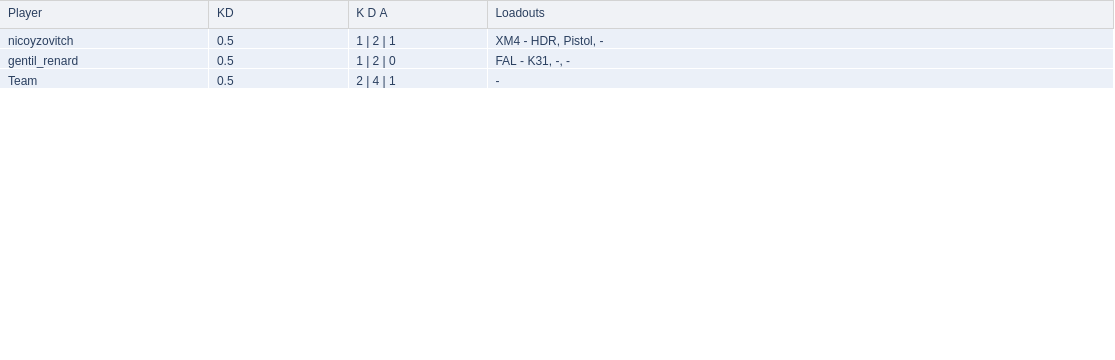

In [220]:
df = team_kills

fig = go.Figure(
    data=[
        go.Table(
            columnwidth = [30, 20, 20, 90],
            header = dict(values=list(df.columns),
                          align=['left'],
                          line_color='lightgray',
                          fill_color='#F0F2F6'),
            cells = dict(values=[df.Player, df.KD, df['K D A'], df.Loadouts],
                         align='left'))
    ]
)

# to narrow spaces between several figures
fig.update_layout(
    width=600,
    height=250,
    margin=dict(
        l=0,
        r=1,
        b=0,
        t=0
        )
    )
fig.show()

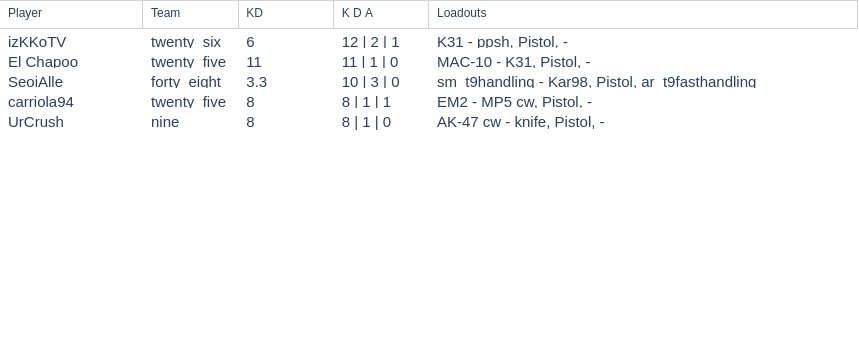

In [233]:
df = top_players

fig = go.Figure(
    data=[
        go.Table(
            columnwidth = [30, 20, 20, 20, 90],
            header = dict(values=list(df.columns),
                          align=['left'],
                          line_color='lightgray',
                          fill_color='white'),
            cells = dict(values=[df.Player, df.Team, df.KD, df['K D A'], df.Loadouts],
                         align='left',
                         fill_color='white', font_size=15))
    ]
)

# to narrow spaces between several figures
fig.update_layout(
    width=1000,
    height=250,
    margin=dict(
        l=0,
        r=1,
        b=0,
        t=0
        )
    )
fig.show()

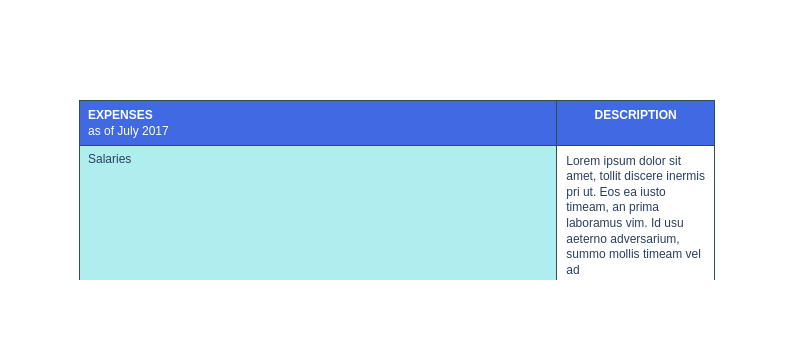

In [60]:
# modele colors, font size,

values = [['Salaries', 'Office', 'Merchandise', 'Legal', '<b>TOTAL<br>EXPENSES</b>'], #1st col
  ["Lorem ipsum dolor sit amet, tollit discere inermis pri ut. Eos ea iusto timeam, an prima laboramus vim. Id usu aeterno adversarium, summo mollis timeam vel ad",
  "Lorem ipsum dolor sit amet, tollit discere inermis pri ut. Eos ea iusto timeam, an prima laboramus vim. Id usu aeterno adversarium, summo mollis timeam vel ad",
  "Lorem ipsum dolor sit amet, tollit discere inermis pri ut. Eos ea iusto timeam, an prima laboramus vim. Id usu aeterno adversarium, summo mollis timeam vel ad",
  "Lorem ipsum dolor sit amet, tollit discere inermis pri ut. Eos ea iusto timeam, an prima laboramus vim. Id usu aeterno adversarium, summo mollis timeam vel ad",
  "Lorem ipsum dolor sit amet, tollit discere inermis pri ut. Eos ea iusto timeam, an prima laboramus vim. Id usu aeterno adversarium, summo mollis timeam vel ad"]]


fig = go.Figure(data=[go.Table(
  columnorder = [1,2],
  columnwidth = [300,100],
  header = dict(
    values = [['<b>EXPENSES</b><br>as of July 2017'],
                  ['<b>DESCRIPTION</b>']],
    line_color='darkslategray',
    fill_color='royalblue',
    align=['left','center'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color='darkslategray',
    fill=dict(color=['paleturquoise', 'white']),
    align=['left', 'center'],
    font_size=12,
    height=30)
    )
])
fig.show()

##### Bullet chart

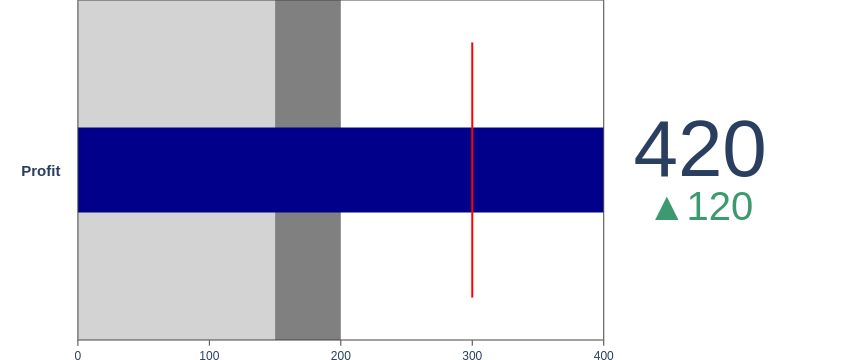

In [223]:
# Model
fig = go.Figure(go.Indicator(
    mode = "number+gauge+delta", value = 420,
    domain = {'x': [0.1, 1], 'y': [0, 1]},
    title = {'text' :"<b>Profit</b>", 'font_size':15},
    delta = {'reference': 300},
    gauge = {
        'shape': "bullet",
        'axis': {'range': [None, 400]},
        'threshold': {
            'line': {'color': "red", 'width': 2},
            'thickness': 0.75,
            'value': 300},
        'steps': [
            {'range': [0, 150], 'color': "lightgray"},
            {'range': [150, 200], 'color': "gray"}],
        'bar': {'color': "darkblue"}
    }))
fig.update_layout(
    height = 80,
    width = 600,
    margin = {'t':0, 'b':20, 'l':0}
)
fig.show()

In [191]:
players_quartiles = playersQuartiles(df)
print('players quartiles: ')
for k, v in players_quartiles.items():
    print(k,v)
player_kills = retrievePlayerKills(df, gamertag)
print('player kills: ', player_kills)
# kpis = ProfileGetKpis(profile)
# player_kd = kpis['br_kd']
lifetime_kd = 0.62
print('lifetime kd: ', lifetime_kd)

players quartiles: 
Kills {'count': 149.0, 'mean': 1.9395973154362416, 'std': 2.322708658533217, 'min': 0.0, '25%': 0.0, '50%': 1.0, '75%': 3.0, 'max': 12.0}
KD {'count': 149.0, 'mean': 1.0771812080536913, 'std': 1.6006384201551922, 'min': 0.0, '25%': 0.0, '50%': 0.5, '75%': 1.5, 'max': 11.0}
player kills:  {'KD': 0.5, 'Kills': 1, 'Deaths': 2}
lifetime kd:  0.62


In [192]:
players_quartiles

{'Kills': {'count': 149.0,
  'mean': 1.9395973154362416,
  'std': 2.322708658533217,
  'min': 0.0,
  '25%': 0.0,
  '50%': 1.0,
  '75%': 3.0,
  'max': 12.0},
 'KD': {'count': 149.0,
  'mean': 1.0771812080536913,
  'std': 1.6006384201551922,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.5,
  '75%': 1.5,
  'max': 11.0}}

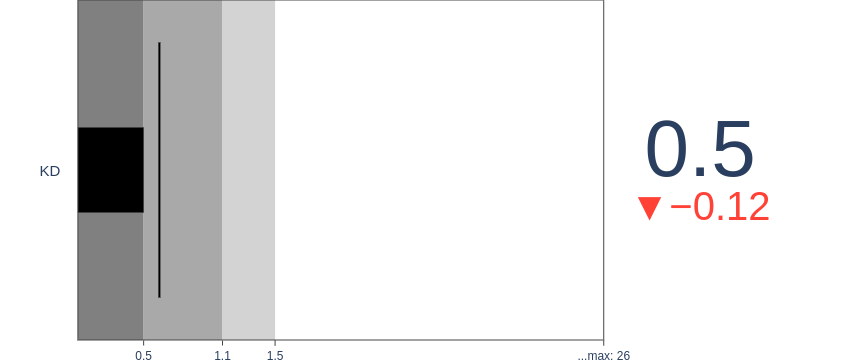

In [225]:
# matche's values
kd_player = player_kills['KD'] if not player_kills['KD'] == 0 else 0.1
kd_mean = round(players_quartiles['KD']['mean'], 1)
kd_median = round(players_quartiles['KD']['50%'],1)
kd_Q3 = round(players_quartiles['KD']['75%'],1)
kd_max = round(players_quartiles['KD']['max'],1)
gauge_length = 4

fig = go.Figure(go.Indicator(
    mode = "number+gauge+delta", value = kd_player,
    domain = {'x': [0.1, 1], 'y': [0, 1]},
    title = {'text' :"KD", 'font_size':15},
    delta = {'reference': lifetime_kd},
    gauge = {
        'shape': "bullet",
        'axis': {'range': [None, gauge_length]},
        'threshold': {
            'line': {'color': "black", 'width': 2},
            'thickness': 0.75,
            'value': lifetime_kd},
        'steps': [
            {'range': [0, kd_median], 'color': "grey"},
            {'range': [kd_median, kd_mean], 'color': "darkgrey"},
            {'range': [kd_mean, kd_Q3], 'color': "lightgrey"}],
        'bar': {'color': "black"}
    }))

fig.update_layout(
    height = 70,
    width = 600,
    margin = {'t':0, 'b':20, 'l':0}
)
ticks = [kd_median, kd_mean, kd_Q3, gauge_length]
fig.update_traces(
    gauge={
        "axis": {
            "tickmode": "array",
            "tickvals": ticks,
            "ticktext": ["...max: 26" if i == gauge_length else i for i in ticks],
        }
    }
)
fig.show()